<a href="https://colab.research.google.com/github/meichenfang/Poisson-regression/blob/main/demos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size="+0"><center> Demonstrations of RADOM on a simulation </center></font> 

# Load packages

In [1]:
%cd ..

# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

import RADOM
print(RADOM.__version__)

from RADOM.inference import Trajectory
from RADOM.poisson_mixture import PoissonMixture
from RADOM.gamma_poisson_mixture import GammaPoissonMixture
from RADOM.preprocess import *
from RADOM.plotting import *

/home/mffang/workspace/Poisson-regression
2023.04.26.22


In [2]:
import numpy as np
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import stats
import copy
from sklearn.decomposition import PCA
import cmasher as cmr
import anndata as ad

In [3]:
plt.rcParams['font.size'] = '24'
label_font = '36'

In [13]:
from RADOM.models.two_species_ss import get_Y

def simulate_demo_data(topo, tau, n=1000, p=200, null_p=100, t_samples=None, loga_mu=2, loga_sd=1, logb_mu=1, logb_sd=0.5, rd_var=0.25, random_seed=42, loomfilepath=None, plot=True):    
    np.random.seed(random_seed)
    L=len(topo)
    K=len(tau)-1
    n_states=len(set(topo.flatten()))
    true_t = []
    if t_samples is None:
        t_samples=np.random.uniform(tau[0],tau[-1],size=100*n)
    
    theta=np.zeros((p,n_states+2))
    for j in range(n_states):
        theta[:,j]=np.random.lognormal(loga_mu, loga_sd,size=p)
    theta[:,-2:]=np.random.lognormal(logb_mu,logb_sd,size=(p,2))
    theta[:,:n_states]/=theta[:,-2,None]
    theta[-null_p:,:n_states]=theta[-null_p:,0,None]
    
    Y = np.zeros((n*L,p,2))
    for l in range(L):
        theta_l = np.concatenate((theta[:,topo[l]], theta[:,-2:]), axis=1)
        t = np.sort(np.random.choice(t_samples,size=n))
        Y[l*n:(l+1)*n] = get_Y(theta_l,t,tau) # m*p*2
        true_t = np.append(true_t,t)
        
    if rd_var != 0:
        read_depth = np.random.gamma(1/rd_var,rd_var,n*L)
        rd = read_depth/read_depth.mean()
    else:
        rd = np.ones(n*L)

    X = np.random.poisson(rd[:,None,None]*Y)
    
    if plot:
        fig, ax = plt.subplots(1,4,figsize=(24,4))
        ax[0].hist(theta[:,:-2].flatten(),bins=100)
        ax[0].set_title("α")
        ax[1].hist(theta[:,-2:].flatten(),bins=10)
        ax[1].set_title("β and γ")
        ax[2].hist(read_depth,bins=100)
        ax[2].set_title("read depth")
        ax[3].hist(true_t,bins=100)
        ax[3].set_title("t")
    
    if loomfilepath is not None:
        adata=ad.AnnData(np.sum(X,axis=-1),dtype=X.dtype)
        adata.layers["spliced"] = X[:,:,1]
        adata.layers["unspliced"] = X[:,:,0]
        adata.layers["ambiguous"]=np.zeros_like(X[:,:,0])
        adata.obs["time"]=true_t
        adata.obs["celltype"]=topo[(np.arange(n*L)//n),np.array(true_t*K/tau[-1],dtype=int)]
        adata.obs["read_depth"]=read_depth
        adata.uns["theta"]=theta
        adata.var["true_beta"]=theta[:,-2]
        adata.var["true_gamma"]=theta[:,-1]
        adata.write_loom(loomfilepath)
        
    return theta, true_t, Y, X, rd

# A complex trajectory as a demonstration

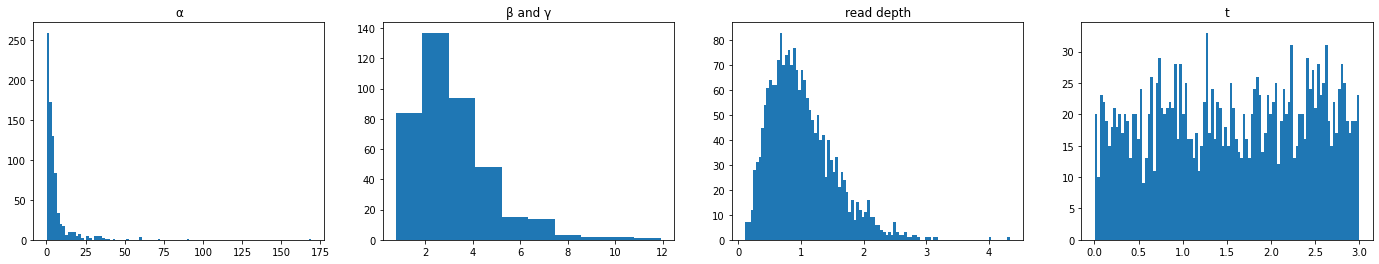

In [5]:
true_topo=np.array([[0,0,1,2],[0,0,1,3]])
topo=np.array([[0,1,2,3],[0,1,2,4]])
tau=(0,1.,2.,3.)
n=1000
L=len(topo)
theta, true_t, Y, X, rd = simulate_demo_data(true_topo, tau, n=1000, random_seed=42, loomfilepath="data/sim_demo.loom")

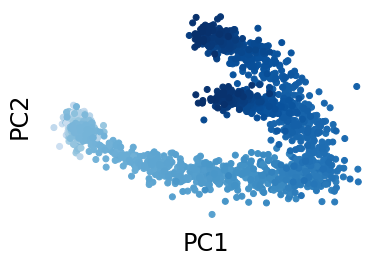

In [6]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.reshape(len(X),-1)/rd[:,None])

cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
ax.scatter(X_pca[:,0],X_pca[:,1],c=true_t,cmap=cmap_y);
#ax.scatter(Y_pca[:,0],Y_pca[:,1],c='yellowgreen');
#ax.scatter(Y_pca[1,67:,0],Y_pca[1,67:,1],c='orange');
#ax.scatter(Y_pca[1,:67,0],Y_pca[1,:67,1],cmap=cmap_y, c=np.arange(67));
#ax.scatter(Y_pca[1,0,0],Y_pca[1,0,1],c='k',s=40);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

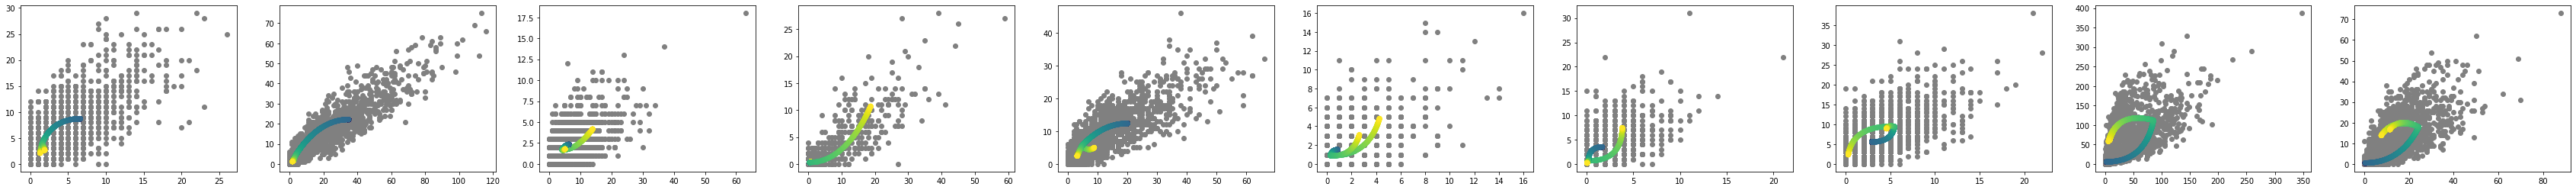

In [7]:
p = 10
fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for i in range(p):
    #ax[i].plot(Y[:,i,1]*gamma[i],Y[:,i,1],'--', color='gray');
    ax[i].scatter(X[:,i,0],X[:,i,1],c='gray');
    ax[i].scatter(Y[:,i,0],Y[:,i,1],c=true_t);
# time increases from blue to red

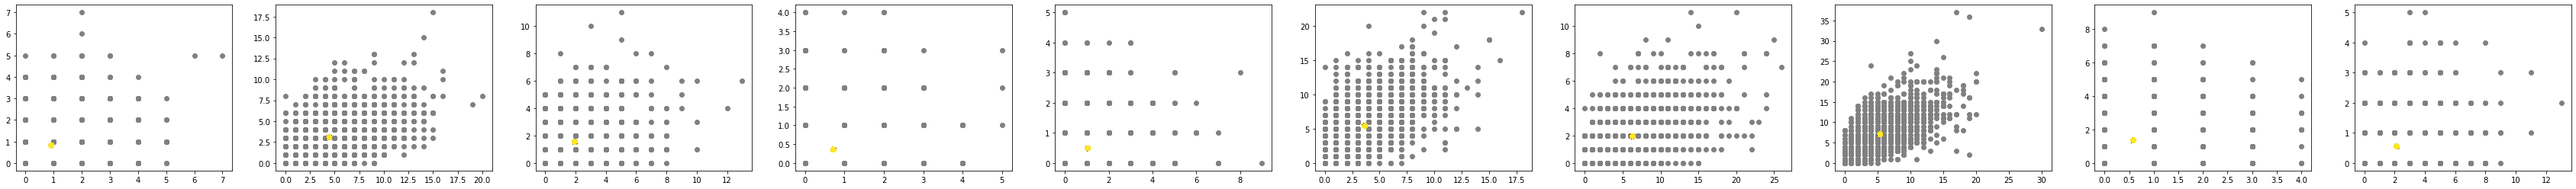

In [8]:
p = 10
fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for i in range(-p,0):
    #ax[i].plot(Y[:,i,1]*gamma[i],Y[:,i,1],'--', color='gray');
    ax[i].scatter(X[:,i,0],X[:,i,1],c='gray');
    ax[i].scatter(Y[:,i,0],Y[:,i,1],c=true_t);
# time increases from blue to red

In [9]:
Elbos = {}

## Fine cluster

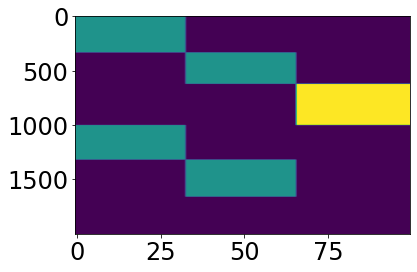

In [175]:
m=100
Q0 = np.zeros((len(X),2,m))

idx = (true_t < 1)
Q0[idx,:,:int(m/3)] += 1

idx = (true_t >= 1) & (true_t < 2)
Q0[idx,:,int(m/3):int(2*m/3)] += 1

idx = (true_t>=2) & (np.arange(n*L)<n)
Q0[idx,0,int(2*m/3):] += 1

idx = (true_t>=2) & (np.arange(n*L)>=n)
Q0[idx,1,int(2*m/3):] += 1

Q0=Q0/Q0.sum(axis=(1,2),keepdims=True)

plt.imshow(Q0[:,0],aspect='auto');

In [176]:
traj_ws = Trajectory(topo, tau, model="two_species_ss", verbose=1)
traj_ws = traj_ws.fit(X,warm_start=True,Q=Q0,norm_Q=True,params={"r":rd},epoch=10,parallel=True,n_threads=10)
Elbos['warm start']=traj_ws.elbos[-1]
traj_ws.elbos[-1]

fitting with warm start


100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


-750.4967056536766

<AxesSubplot:>

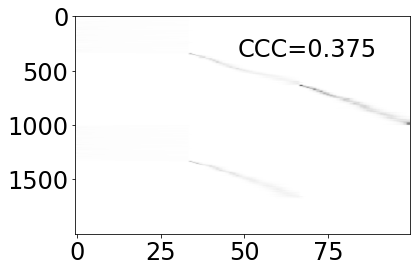

In [177]:
plot_t(traj_ws,l=0,t=true_t)

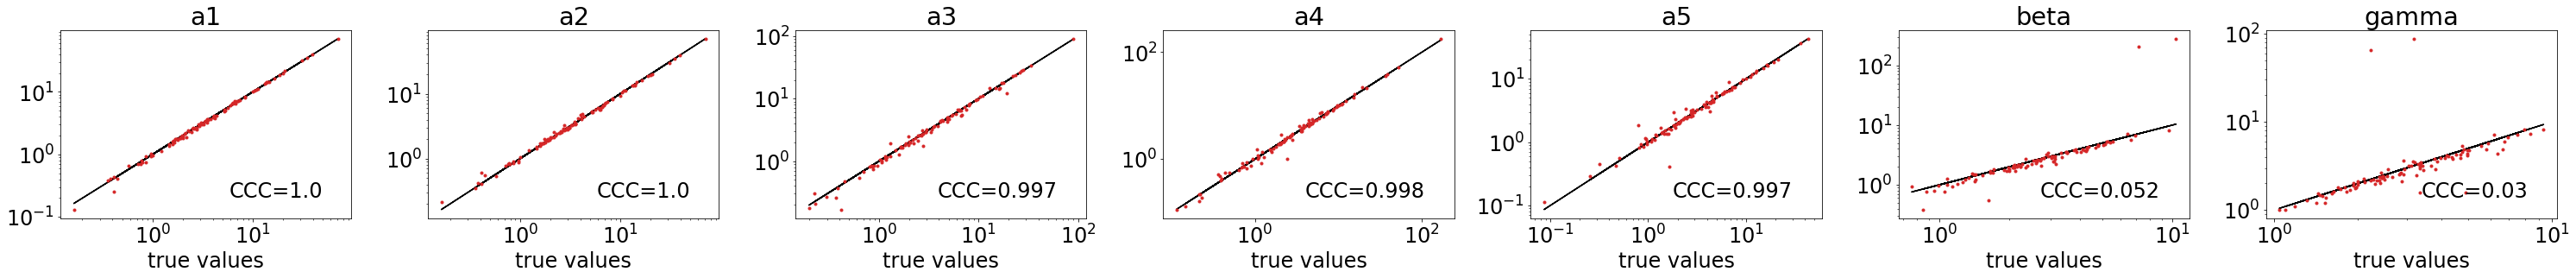

In [178]:
ax = plot_theta(theta[:100,[0,0,1,2,3,-2,-1]], traj_ws.theta[:100,[0,1,2,3,4,-2,-1]], dot_color='tab:red')

In [96]:
traj = Trajectory(np.array([[0,1,2,3],[0,1,2,4]]),tau = (0,1,2,3), model="two_species_ss_tau", verbose=1)
traj = traj.fit(X,warm_start=True,Q=Q0,params={"r":rd},beta=1,epoch=10,parallel=True,n_threads=10)
traj.elbos[-1]

fitting with warm start


100%|██████████| 10/10 [02:09<00:00, 12.98s/it]


-1506.603848393172

<AxesSubplot:>

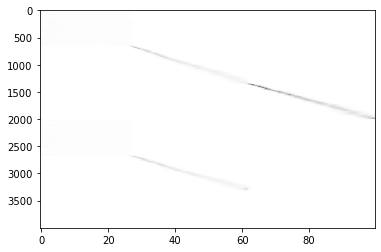

In [97]:
plot_t(traj,l=0)

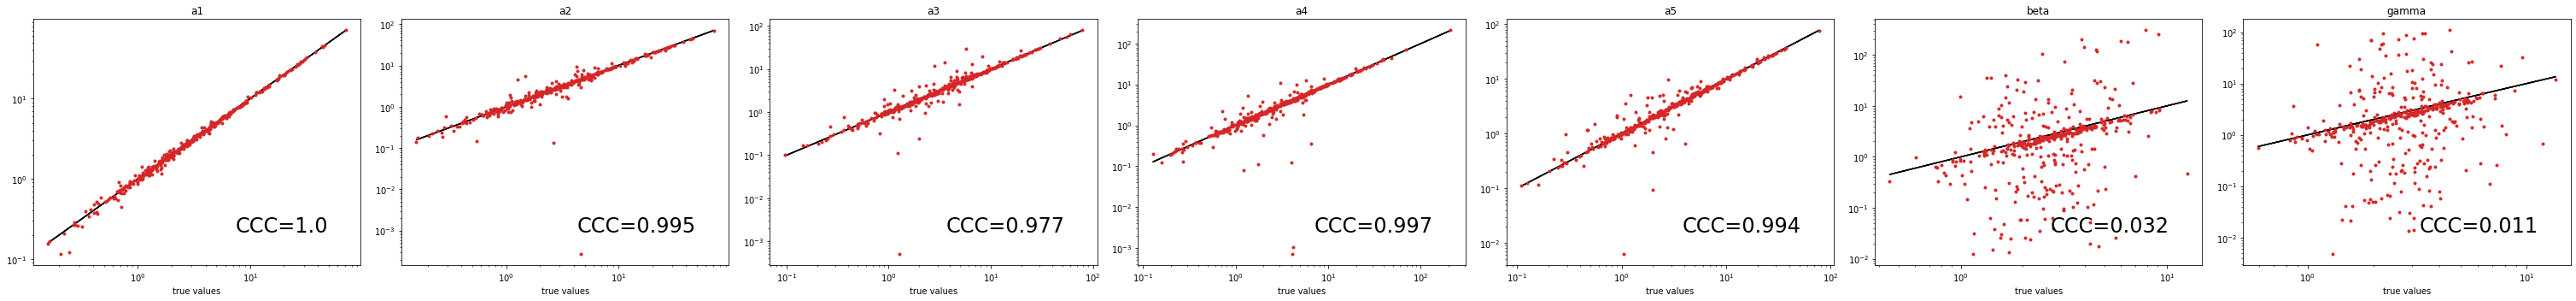

In [99]:
ax = plot_theta(theta[:,[0,0,1,2,3,-2,-1]], traj.theta[:,[0,1,2,3,4,-2,-1]], dot_color='tab:red')

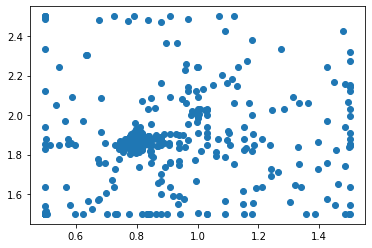

In [100]:
plt.scatter(traj.theta[:,-4],traj.theta[:,-3])

In [92]:
traj = Trajectory(np.array([[0,1,2,3],[0,1,2,4]]),tau = (0,1,2,3), model="two_species_tau", verbose=2)
traj = traj.fit(X,Q=Q0,params={"lambda_tau":lambda_tau},beta=1,epoch=10,parallel=True,n_threads=10)

run method fit_warm_start


100%|██████████| 10/10 [01:02<00:00,  6.28s/it]


20815.809710992024

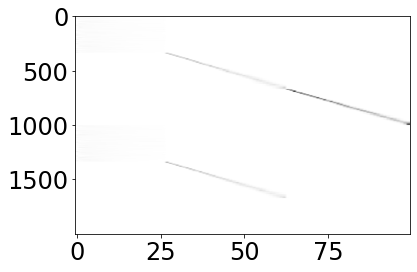

In [93]:
plot_t(traj,l=0)
traj.compute_lower_bound(X)

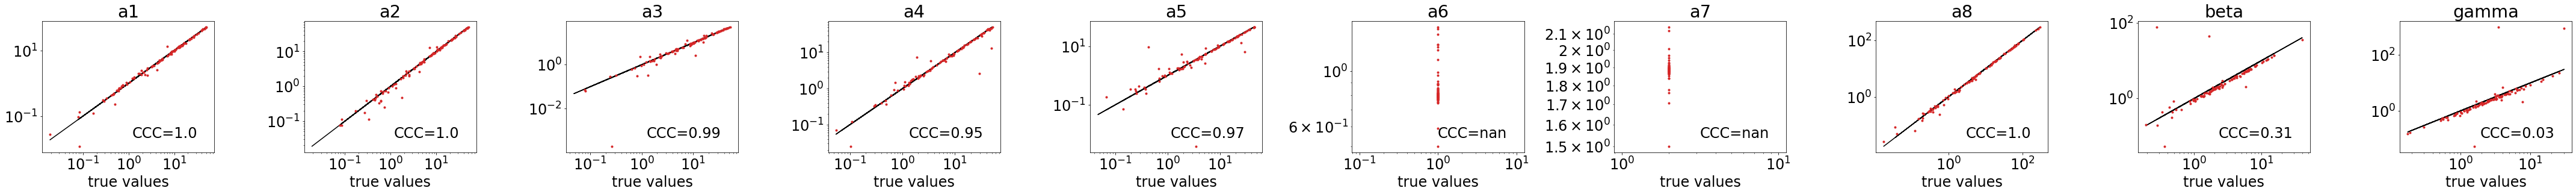

In [94]:
ax = plot_theta(theta[:100], traj.theta[:100], dot_color='tab:red')

## Coarse clusters

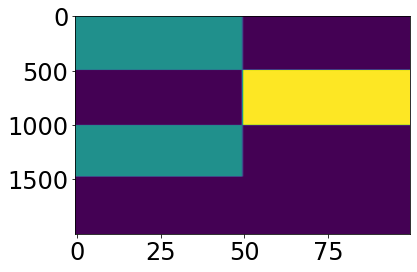

In [180]:
m=100
Q0 = np.zeros((len(X),2,m))

idx = (true_t < 1.5)
Q0[idx,:,:int(m/2)] += 1

idx = (true_t>=1.5) & (np.arange(n*L)<n)
Q0[idx,0,int(m/2):] += 1

idx = (true_t>=1.5) & (np.arange(n*L)>=n)
Q0[idx,1,m//2:] += 1

Q0=Q0/Q0.sum(axis=(1,2),keepdims=True)

plt.imshow(Q0[:,0],aspect='auto');

In [182]:
traj_ws2 = Trajectory(topo, tau, model="two_species_ss", verbose=2)
traj_ws2 = traj_ws2.fit(X,warm_start=True,Q=Q0,params={'r':rd},epoch=10,parallel=True,n_threads=10)
traj_ws2.elbos[-1]

fitting with warm start


100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


-750.7483874626134

<AxesSubplot:>

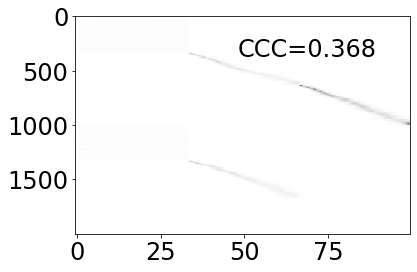

In [186]:
plot_t(traj_ws2,l=0,t=true_t)

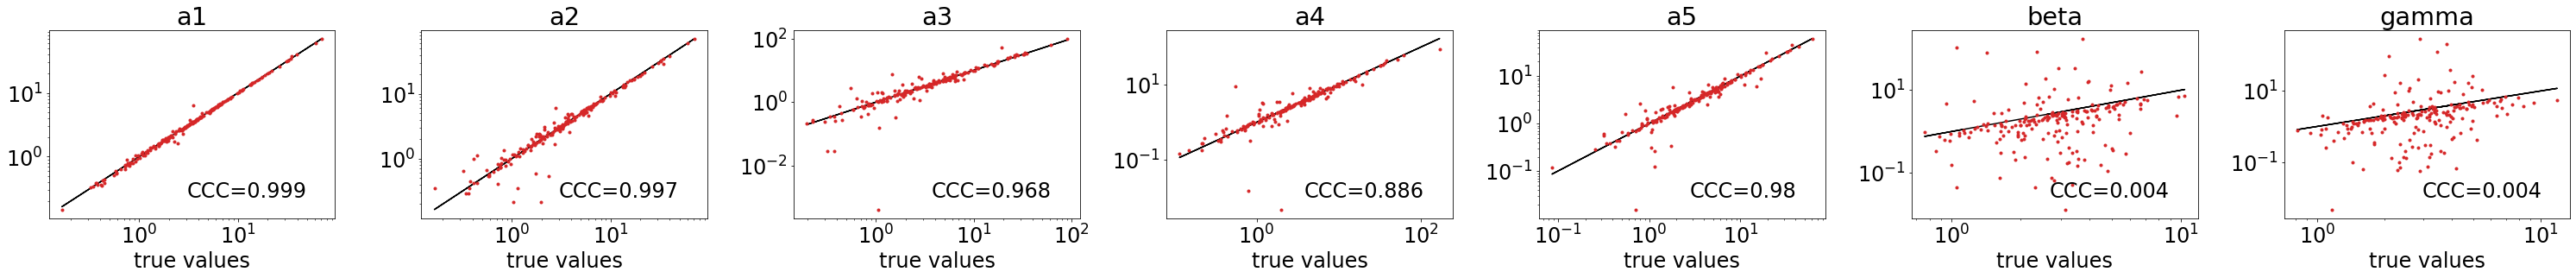

In [187]:
ax = plot_theta(theta[:,[0,0,1,2,3,-2,-1]], traj.theta, dot_color='tab:red')

## Random initialization

In [188]:
from multiprocessing import Pool

Input_args = []

def fit_wrapper(seed):
    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X,m=100,n_init=1,params={'r':rd},perm_theta=False,epoch=10,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    trajs = pool.starmap(fit_wrapper, Input_args, chunksize=1)

In [190]:
with open('simulations/simulation_results/sim_demo.pickle', 'wb') as f:
    pickle.dump(trajs, f, pickle.HIGHEST_PROTOCOL)

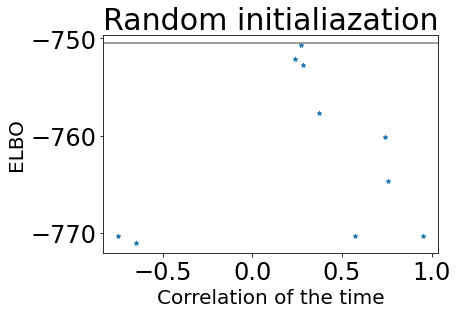

In [333]:
corrs = []
elbos = []
for traj in trajs[:10]:
    right_t = true_t.copy()
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(stats.spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20',s=20,marker='*')
plt.axhline(y=Elbos['warm start'],color='gray')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

traj = trajs[np.argmax(elbos)]

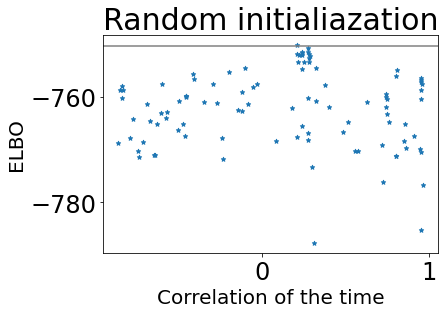

In [334]:
corrs = []
elbos = []
for traj in trajs[:100]:
    right_t = true_t.copy()
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(stats.spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20',s=20,marker='*')
plt.axhline(y=Elbos['warm start'],color='gray')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

traj = trajs[np.argmax(elbos)]

In [263]:
traj.elbos

[[-935.3767941596627,
  -923.5720205720935,
  -757.1324641013047,
  -752.1177479344833,
  -750.4860116673339,
  -750.3428713811534,
  -750.3036707873574,
  -750.2884763974172,
  -750.2812159827108,
  -750.2773161804414,
  -750.2731307398749]]

<AxesSubplot:>

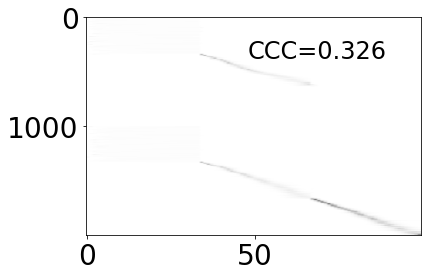

In [264]:
plot_t(traj,l=0,t=true_t)

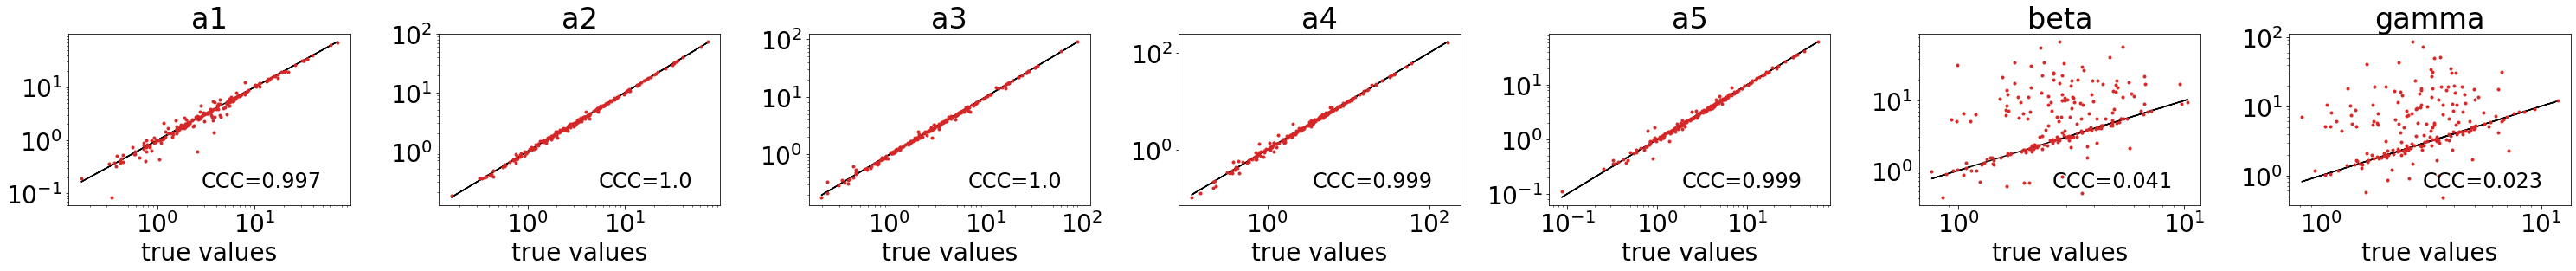

In [265]:
ax = plot_theta(theta[:,[0,0,1,2,3,-2,-1]], traj.theta[:,[0,1,2,4,3,-2,-1]], dot_color='tab:red')

## ELBO plot

In [199]:
complete_L = np.mean((X*np.log(rd[:,None,None]*Y)-rd[:,None,None]*Y-gammaln(X+1)).sum(axis=(-1,-2)))
complete_L

-747.7947726793426

In [200]:
true_theta = theta[:,[0,0,1,2,3,-2,-1]]
traj_true = Trajectory(topo, tau, model="two_species_ss", verbose=1)
traj_true = traj_true.fit(X,warm_start=True,theta=true_theta,norm_Q=True,params={"r":rd},epoch=0,parallel=False,n_threads=1)
true_L = traj_true.elbos
true_L

fitting with warm start


0it [00:00, ?it/s]


[-750.5406602204721]

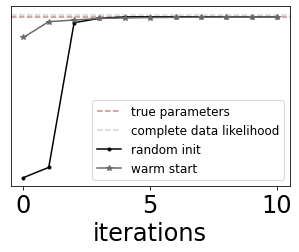

In [330]:
plt.rcParams['font.size'] = '24'

fig, ax = plt.subplots(1,1,figsize=(5,3.3))

ax.axhline(y=true_L,ls='--',color='rosybrown',label='true parameters')
ax.axhline(y=complete_L,ls='--',color='lightgray',label='complete data likelihood')

ax.plot(traj.elbos[0],'.-',label='random init',color='k')
ax.plot(traj_ws.elbos,'*-',label='warm start',color='dimgray')

ax.set_xlabel('iterations',fontsize=24)
#ax.set_yscale('log')
ax.axes.get_yaxis().set_visible(False)
ax.set_ylabel('ELBO',fontsize=24);
plt.legend(fontsize=12);

## PCA plots

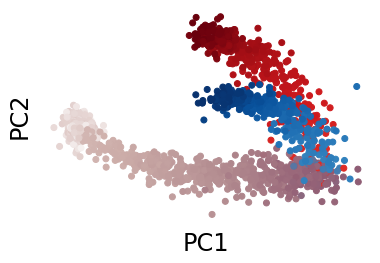

In [236]:
cmap_1 = cmr.get_sub_cmap('Blues', 0., 1)
cmap_2 = cmr.get_sub_cmap('Reds', 0., 1)

color_1 = traj.Q[:,0]@np.array(cmap_1(traj.t/tau[-1]))[:,:3]
color_2 = traj.Q[:,1]@np.array(cmap_2(traj.t/tau[-1]))[:,:3]
t_color = color_1 + color_2

fig, ax = plt.subplots(1,1)
ax.scatter(X_pca[:,0],X_pca[:,1],c=t_color);

ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

## Plot Q

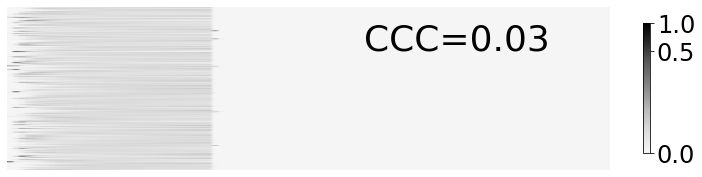

In [208]:
import matplotlib.colors as colors
def _forward(x):
    return np.log(0.05+x)


def _inverse(x):
    return np.exp(x)-0.05

norm = colors.FuncNorm((_forward, _inverse), vmin=0, vmax=1)

plt.rcParams['font.size'] = '24'

fig, ax = plt.subplots(1,1,figsize=(12,3))

cmap_Q = cmr.get_sub_cmap('Greys', 0.08, 1)
cell_idx = (true_t<1)
Z = traj.Q[cell_idx,0,:] + traj.Q[cell_idx,1,:]
im = ax.imshow(Z,aspect="auto",cmap=cmap_Q, norm=norm);

t_hat=traj.Q[:,0,:]@traj.t+traj.Q[:,1,:]@traj.t
ax.text(0.9, 0.9, "CCC="+str(np.around(CCC(t_hat[cell_idx],true_t[cell_idx]),2)), horizontalalignment='right', 
                 verticalalignment='top', transform=ax.transAxes, color="black",fontsize=36);
cbar = plt.colorbar(im,fraction=0.05, shrink =0.8) # adding the colobar on the right
ax.axis('off');

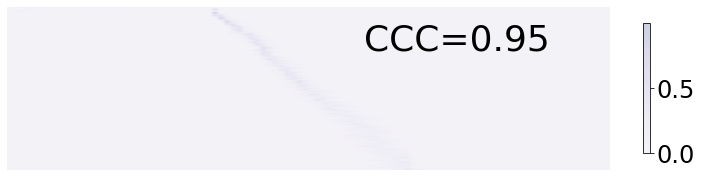

In [238]:
fig, ax = plt.subplots(1,1,figsize=(12,3))

cmap_Q = cmr.get_sub_cmap('Purples', 0.08, 0.3)
cell_idx = (true_t>=1) & (true_t<2)
Z = traj.Q[cell_idx,0,:][np.argsort(true_t[cell_idx])] + traj.Q[cell_idx,1,:][np.argsort(true_t[cell_idx])]
im = ax.imshow(Z,aspect="auto",cmap=cmap_Q);

t_hat=traj.Q[:,0,:]@traj.t+traj.Q[:,1,:]@traj.t
ax.text(0.9, 0.9, "CCC="+str(np.around(CCC(t_hat[cell_idx],true_t[cell_idx]),2)), horizontalalignment='right', 
                 verticalalignment='top', transform=ax.transAxes, color="black",fontsize=36);
plt.colorbar(im,fraction=0.05, shrink =0.8) # adding the colobar on the right
ax.axis('off');

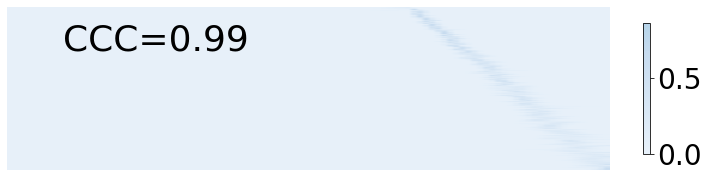

In [287]:
fig, ax = plt.subplots(1,1,figsize=(12,3))

cmap_Q = cmr.get_sub_cmap('Blues', 0.08, 0.3)
cell_idx = (true_t>=2) & (np.arange(2000)>=1000)
Z = traj.Q[cell_idx,0,:][np.argsort(true_t[cell_idx])]
im = ax.imshow(Z,aspect="auto",cmap=cmap_Q);

t_hat=traj.Q[:,0,:]@traj.t+traj.Q[:,1,:]@traj.t
ax.text(0.4, 0.9, "CCC="+str(np.around(CCC(t_hat[cell_idx],true_t[cell_idx]),2)), horizontalalignment='right', 
                 verticalalignment='top', transform=ax.transAxes, color="black",fontsize=36);

plt.colorbar(im,fraction=0.05, shrink =0.8) # adding the colobar on the right
ax.axis('off');

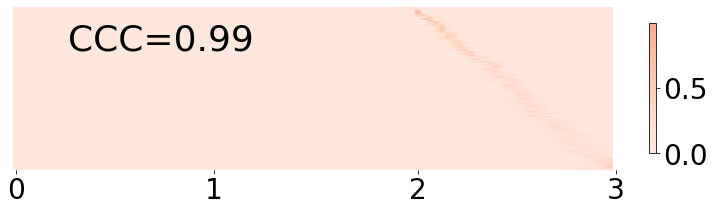

In [288]:
fig, ax = plt.subplots(1,1,figsize=(12,3))

cmap_Q = cmr.get_sub_cmap('Reds', 0.08, 0.3)
cell_idx = (true_t>=2) & (np.arange(2000)<=1000)
Z = traj.Q[cell_idx,1,:][np.argsort(true_t[cell_idx])]
im = ax.imshow(Z,aspect="auto",cmap=cmap_Q);

t_hat=traj.Q[:,0,:]@traj.t+traj.Q[:,1,:]@traj.t
ax.text(0.4, 0.9, "CCC="+str(np.around(CCC(t_hat[cell_idx],true_t[cell_idx]),2)), horizontalalignment='right', 
                 verticalalignment='top', transform=ax.transAxes, color="black",fontsize=36);

plt.colorbar(im,fraction=0.05, shrink =0.8) # adding the colobar on the right
x_label_list = ['0', '1', '2', '3']
ax.set_xticks([0,33,67,100])
ax.set_xticklabels(x_label_list)
ax.set_yticks([])
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

## Plot theta

In [299]:
plt.rcParams['font.size'] = '28'
label_font = 36
      
def plot_theta_ss(theta,theta_hat,dot_color='grey'):
    K=np.shape(theta)[1]
    fig, ax = plt.subplots(1,K,figsize=(6*K,5))

    for i in range(K):
        ax[i].plot(theta[:,i],theta[:,i],color='black');
        ax[i].plot(theta[:,i],theta_hat[:,i],'.',color=dot_color);
        ax[i].text(0.95, 0.2, "CCC="+str(np.around(CCC(theta_hat[:,i],theta[:,i]),2)), horizontalalignment='right', 
                 verticalalignment='top', transform=ax[i].transAxes, color="black",fontsize=label_font);
        #ax[i+1].set_title("α"+str(i+1), fontsize = label_font)
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
    #fig.supxlabel("true values", fontsize = label_font);
    #fig.supylabel("estimates", fontsize = label_font)
    plt.tight_layout()
    
    return fig

In [300]:
true_theta = theta[:,[0,0,1,2,3,-2,-1]]
theta_hat = traj.theta[:,[0,1,2,4,3,-2,-1]]

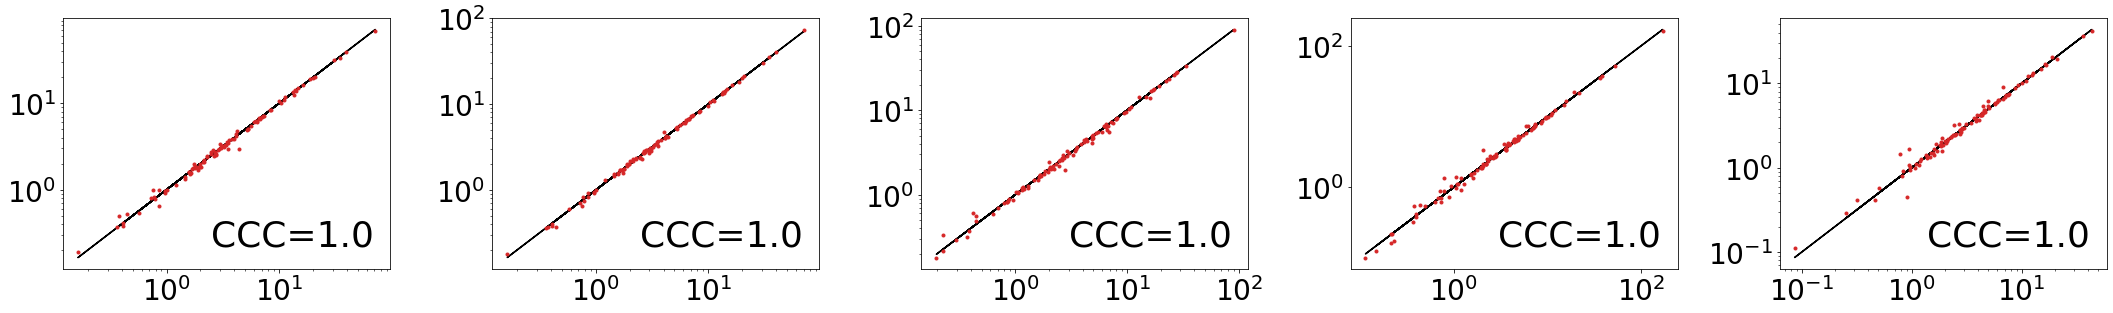

In [301]:
fig = plot_theta_ss(true_theta[:100,:-2], theta_hat[:100,:-2], dot_color='tab:red')

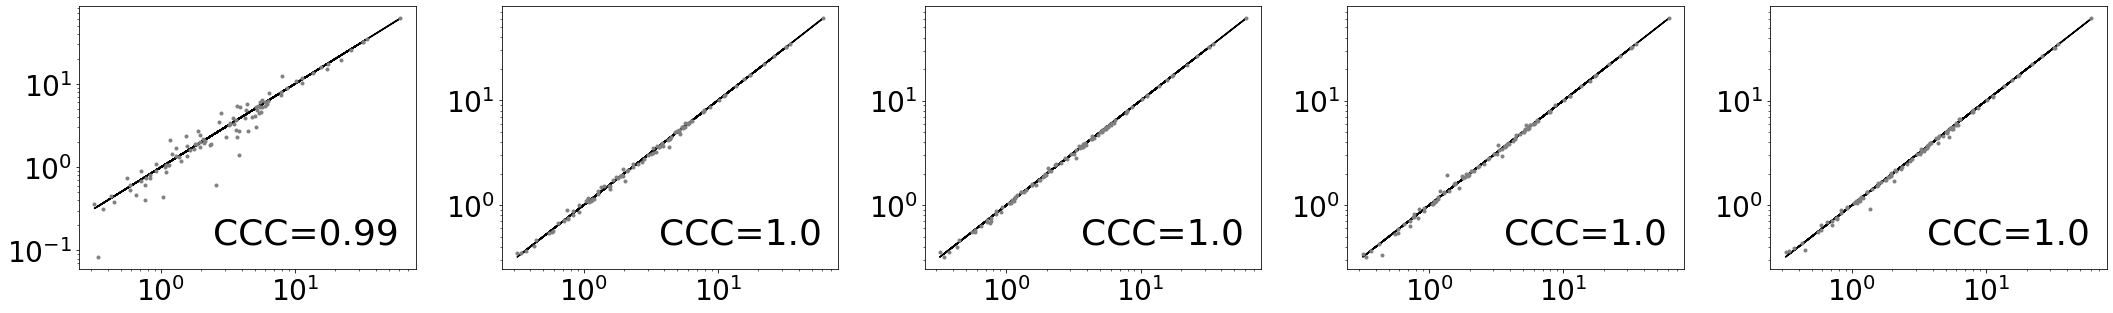

In [302]:
theta_hat[100:,-1] = true_theta[100:,-2]*theta_hat[100:,-1]/theta_hat[100:,-2]
fig = plot_theta_ss(true_theta[100:,:-2], theta_hat[100:,:-2])

[]

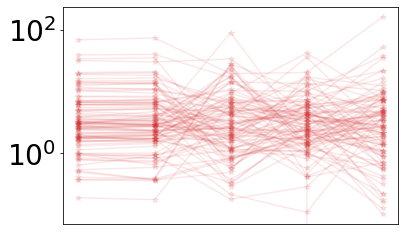

In [304]:
fig,ax = plt.subplots(1,1)
for j in range(100):
    ax.plot(traj.theta[j,[0,1,2,3,4]],'-*',color='tab:red',alpha=0.1)

ax.set_yscale('log')
x_label_list = ['α0', 'α1', 'α2', 'α3', 'α4']
ax.set_xticks([])
#ax.set_xticks([0,1,2,3,4])
#ax.set_xticklabels(x_label_list)

[]

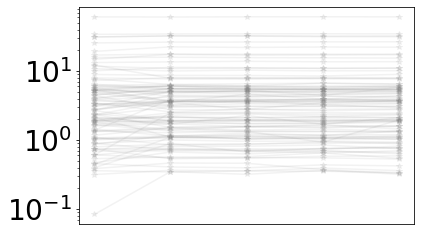

In [305]:
fig,ax = plt.subplots(1,1)
for j in range(100):
    ax.plot(traj.theta[j+100,[0,1,2,3,4]],'-*',color='gray',alpha=0.1)
x_label_list = ['α0', 'α1', 'α2', 'α3', 'α4']
ax.set_yscale('log')
ax.set_xticks([])
#ax.set_xticks([0,1,2,3,4])
#ax.set_xticklabels(x_label_list)

## Model selection

In [40]:
true_topo=np.array([[0,0,1,2],[0,0,1,3]])
topo=np.array([[0,1,2,3],[0,1,2,4]])
topo3 = np.array([[0,1,2,3],[0,1,4,5]])
tau=(0,1.,2.,3.)
m=100
L=len(topo)

In [48]:
n=5000
#trajs_5000=[]

for seed in tqdm(range(10,20)):
    theta, true_t, Y, X, rd = simulate_demo_data(true_topo, tau, n=n, random_seed=seed, loomfilepath=None, plot=False);

    Q0 = np.zeros((n*L,2,m))
    idx = (true_t < 1.5)
    Q0[idx,:,:int(m/2)] += 1

    idx = (true_t>=1.5) & (np.arange(n*L)<n)
    Q0[idx,0,int(m/2):] += 1

    idx = (true_t>=1.5) & (np.arange(n*L)>=n)
    Q0[idx,1,m//2:] += 1

    Q0=Q0/Q0.sum(axis=(1,2),keepdims=True)
    
    traj0 = Trajectory(true_topo, tau, model="two_species_ss", verbose=0)
    traj0 = traj0.fit(X,warm_start=True,Q=Q0,params={'r':rd},epoch=100,parallel=True,n_threads=10)
    
    traj1 = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj1 = traj1.fit(X,warm_start=True,Q=Q0,params={'r':rd},epoch=100,parallel=True,n_threads=10)
    
    traj2 = Trajectory(topo, tau, model="two_species", verbose=0)
    traj2 = traj2.fit(X,warm_start=True,Q=Q0,params={'r':rd},epoch=100,parallel=True,n_threads=10)
    
    traj3 = Trajectory(topo3, tau, model="two_species_ss", verbose=0)
    traj3 = traj3.fit(X,warm_start=True,Q=Q0,params={'r':rd},epoch=100,parallel=True,n_threads=10)
    
    trajs_5000.append((traj0,traj1,traj2,traj3))


100%|██████████| 10/10 [9:20:36<00:00, 3363.62s/it] 


In [52]:
n=1000
trajs_1000=[]

for seed in tqdm(range(100)):
    theta, true_t, Y, X, rd = simulate_demo_data(true_topo, tau, n=n, random_seed=seed, loomfilepath=None, plot=False);

    Q0 = np.zeros((n*L,2,m))
    idx = (true_t < 1.5)
    Q0[idx,:,:int(m/2)] += 1

    idx = (true_t>=1.5) & (np.arange(n*L)<n)
    Q0[idx,0,int(m/2):] += 1

    idx = (true_t>=1.5) & (np.arange(n*L)>=n)
    Q0[idx,1,m//2:] += 1

    Q0=Q0/Q0.sum(axis=(1,2),keepdims=True)
    
    traj0 = Trajectory(true_topo, tau, model="two_species_ss", verbose=0)
    traj0 = traj0.fit(X,warm_start=True,Q=Q0,params={'r':rd},epoch=100,parallel=True,n_threads=10)
    
    traj1 = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj1 = traj1.fit(X,warm_start=True,Q=Q0,params={'r':rd},epoch=100,parallel=True,n_threads=10)
    
    traj2 = Trajectory(topo, tau, model="two_species", verbose=0)
    traj2 = traj2.fit(X,warm_start=True,Q=Q0,params={'r':rd},epoch=100,parallel=True,n_threads=10)
    
    traj3 = Trajectory(topo3, tau, model="two_species_ss", verbose=0)
    traj3 = traj3.fit(X,warm_start=True,Q=Q0,params={'r':rd},epoch=100,parallel=True,n_threads=10)
    
    trajs_1000.append((traj0,traj1,traj2,traj3))


100%|██████████| 100/100 [15:04:06<00:00, 542.46s/it] 


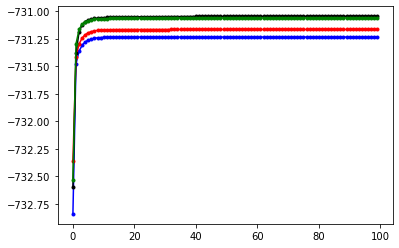

In [49]:
plt.plot(traj0.elbos[1:],'b.-')
plt.plot(traj1.elbos[1:],'r.-')
plt.plot(traj2.elbos[1:],'k.-')
plt.plot(traj3.elbos[1:],'g.-')

In [64]:
x=[]
y=[]
for trajs in trajs_5000:
    AIC = []
    BIC = []
    for traj in trajs:
        AIC.append(traj.compute_AIC(traj.X))
        BIC.append(traj.compute_BIC(traj.X))
    x.append(np.argmin(AIC))
    y.append(np.argmin(BIC))

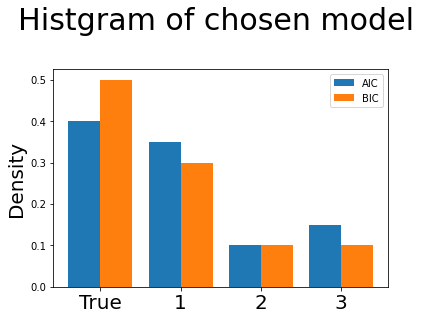

In [71]:
plt.hist([x,y],label=["AIC","BIC"],density=True,bins=np.arange(5)-0.5)
plt.legend()

x_label_list = ['True', '1', '2', '3']
plt.xticks([0,1,2,3],x_label_list,fontsize=20);
plt.ylabel("Density",fontsize=20);
plt.title("Histgram of chosen model \n",fontsize=30);

In [62]:
x=[]
y=[]
for trajs in trajs_1000:
    AIC = []
    BIC = []
    for traj in trajs:
        AIC.append(traj.compute_AIC(traj.X))
        BIC.append(traj.compute_BIC(traj.X))
    x.append(np.argmin(AIC))
    y.append(np.argmin(BIC))
plt.hist([x,y],label=["AIC","BIC"],density=True,bins=np.arange(5)-0.5)
plt.legend()

KeyboardInterrupt: 

In [100]:
traj0 = Trajectory(true_topo, tau, model="two_species_ss", verbose=2)
traj0 = traj0.fit(X,warm_start=True,Q=Q0,params={'r':rd},epoch=10,parallel=True,n_threads=10)
traj0.elbos[-1]

fitting with warm start


100%|██████████| 10/10 [01:20<00:00,  8.09s/it]


-719.3426924849039

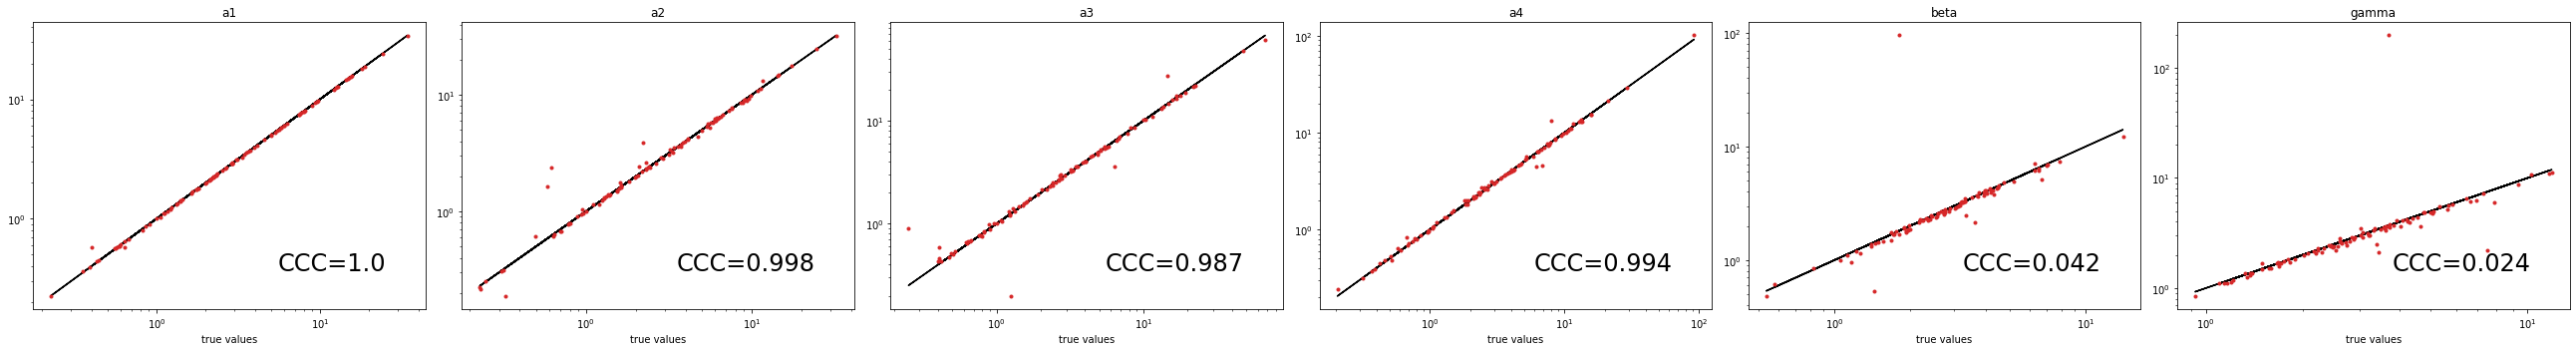

In [101]:
ax = plot_theta(theta[:100], traj0.theta[:100], dot_color='tab:red')

In [102]:
traj1 = Trajectory(topo, tau, model="two_species_ss", verbose=2)
traj1 = traj1.fit(X,warm_start=True,Q=Q0,params={'r':rd},epoch=10,parallel=True,n_threads=10)
traj1.elbos[-1]

fitting with warm start


100%|██████████| 10/10 [01:20<00:00,  8.01s/it]


-718.8650860535785

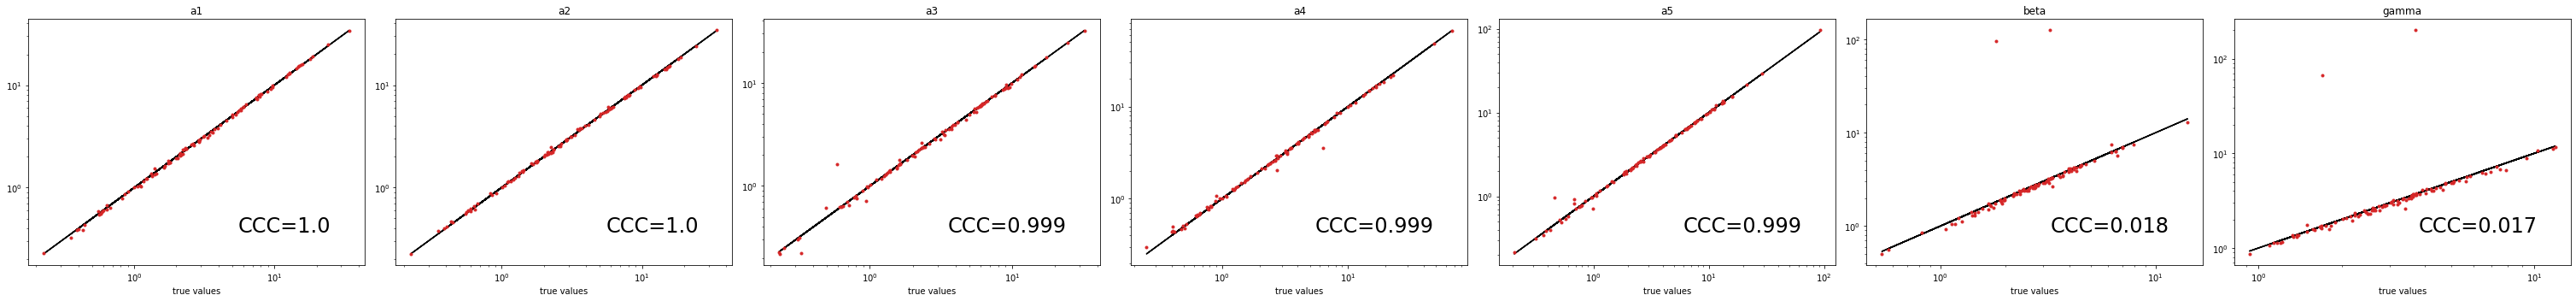

In [103]:
ax = plot_theta(theta[:100,[0,0,1,2,3,-2,-1]], traj1.theta[:100,[0,1,2,3,4,-2,-1]], dot_color='tab:red')

In [104]:
trajs = Trajectory(topo, tau, model="two_species", verbose=2)
trajs = trajs.fit(X,warm_start=True,Q=Q0,params={'r':rd},epoch=10,parallel=True,n_threads=10)
trajs.elbos[-1]

fitting with warm start


100%|██████████| 10/10 [01:17<00:00,  7.72s/it]


-718.7899455860698

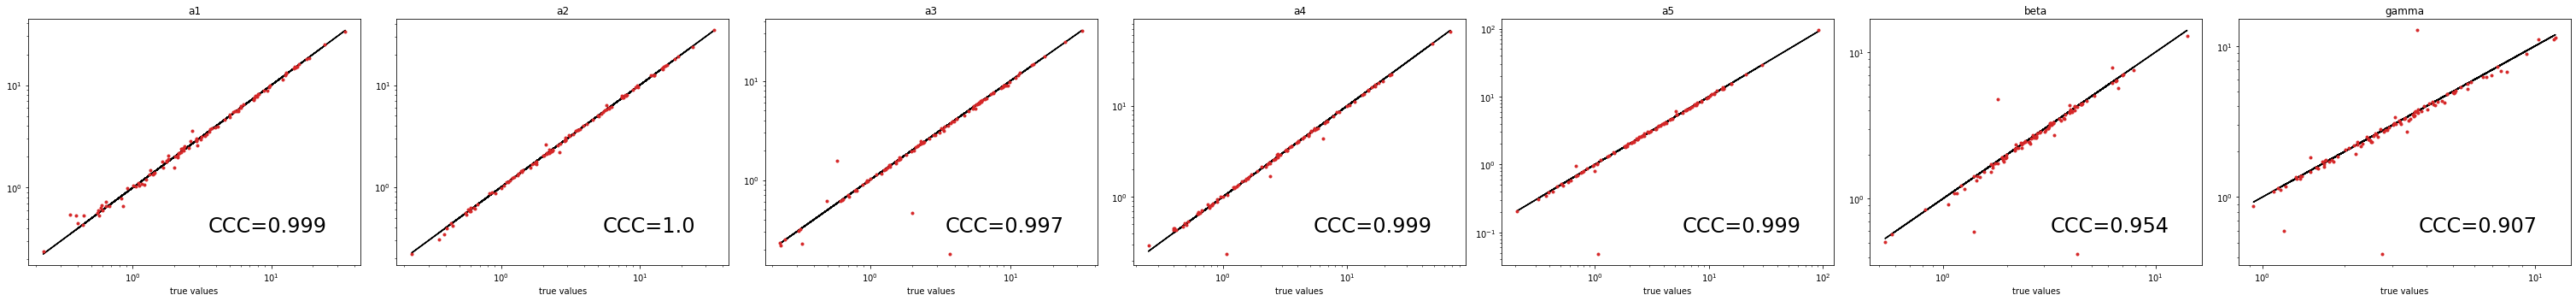

In [105]:
ax = plot_theta(theta[:100,[0,0,1,2,3,-2,-1]], trajs.theta[:100,[0,1,2,3,4,-2,-1]], dot_color='tab:red')

In [106]:
topo2 = np.array([[0,1,2,3,4],[0,1,2,3,5]])
tau2 = (0,1,2,3,4)

traj2 = Trajectory(topo2, tau2, model="two_species_ss", verbose=2)
traj2 = traj2.fit(X,warm_start=True,Q=Q0,params={'r':rd},epoch=10,parallel=True,n_threads=10)
traj2.elbos[-1]

fitting with warm start


100%|██████████| 10/10 [01:19<00:00,  7.99s/it]


-720.4339657572541

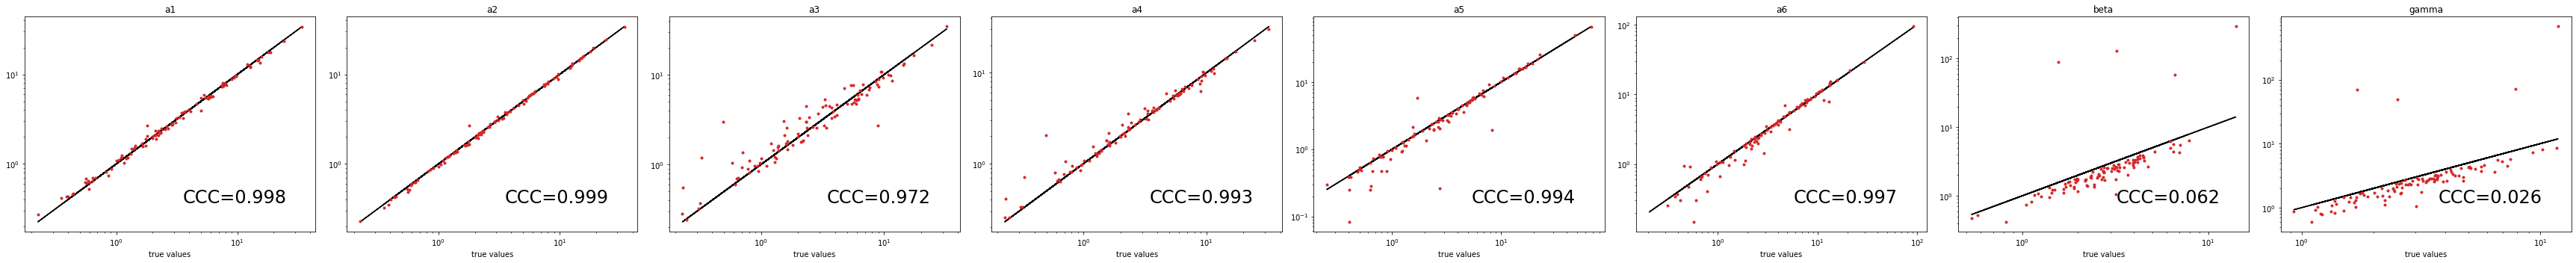

In [107]:
ax = plot_theta(theta[:100,[0,0,1,1,2,3,-2,-1]], traj2.theta[:100,[0,1,2,3,4,5,-2,-1]], dot_color='tab:red')

In [108]:
topo3 = np.array([[0,1,2,3],[0,1,4,5]])
tau3 = (0,1,2,3)

traj3 = Trajectory(topo3, tau3, model="two_species_ss", verbose=2)
traj3 = traj3.fit(X,warm_start=True,Q=Q0,params={'r':rd},epoch=10,parallel=True,n_threads=10)
traj3.elbos[-1]

fitting with warm start


100%|██████████| 10/10 [01:19<00:00,  7.97s/it]


-719.0201156503535

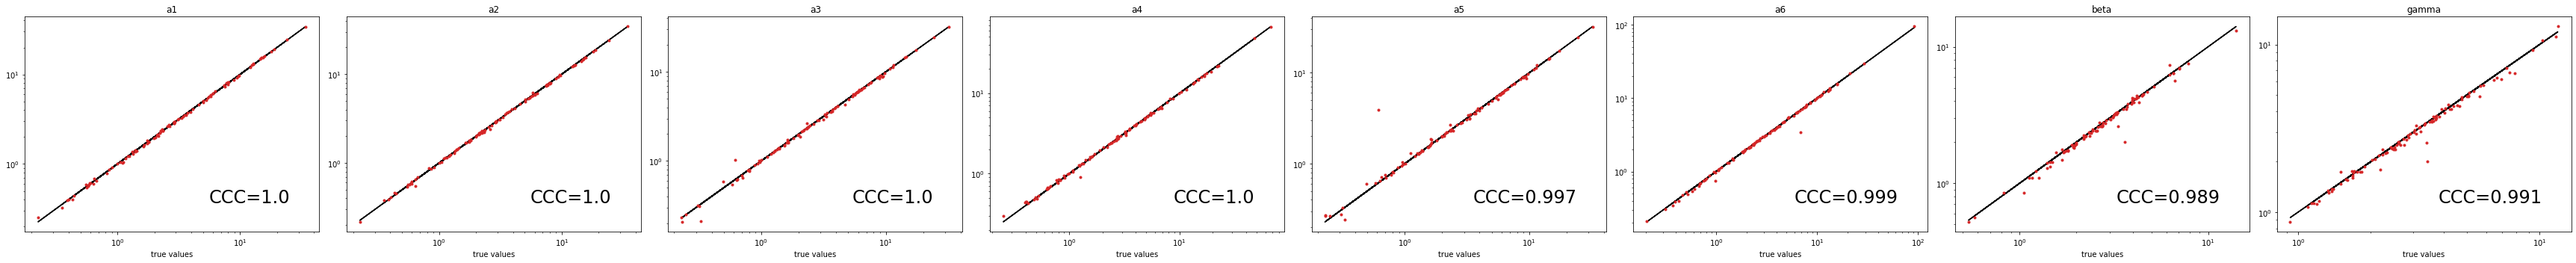

In [109]:
ax = plot_theta(theta[:100,[0,0,1,2,1,3,-2,-1]], traj3.theta[:100,[0,1,2,3,4,5,-2,-1]], dot_color='tab:red')

In [110]:
def compute_AICc(traj):
    return traj.compute_AIC(X)+2*traj.k*(traj.k+1)/(n-traj.k-1)

**smaller AIC or BIC is better**

In [111]:
traj0.compute_AIC(X),traj0.compute_BIC(X), compute_AICc(traj0)

(28776107.699396156, 28785591.884459198, 28776435.282076005)

In [112]:
traj1.compute_AIC(X),traj1.compute_BIC(X), compute_AICc(traj1)

(28757403.44214314, 28768468.32471669, 28757859.63472367)

In [113]:
trajs.compute_AIC(X),trajs.compute_BIC(X), compute_AICc(trajs)

(28754797.823442794, 28767443.403526854, 28755407.800821055)

In [114]:
traj2.compute_AIC(X),traj2.compute_BIC(X), compute_AICc(traj2)

(28820558.630290166, 28833204.210374225, 28821168.607668426)

In [115]:
traj3.compute_AIC(X),traj3.compute_BIC(X), compute_AICc(traj3)

(28764004.626014143, 28776650.206098203, 28764614.603392404)

In [ ]:
accepts = []
diffs = []
for j in range(100):
    nested_model = {j:[[0],[-3]]}
    accept, diff, _ = traj.compare_model(X, nested_model, epoch=10, parallel=False)
    accepts.append(accept)
    diffs.append(diff)
accepts = np.array(accepts,dtype=bool)

In [ ]:
accepts

In [ ]:
_.compute_AIC(X)

In [ ]:
_.compute_lower_bound(X)

In [ ]:
traj.compute_AIC(X)

In [ ]:
traj.compute_lower_bound(X)

In [ ]:
plot_phase(_,idx=np.arange(5))

**pie plot**

In [ ]:
models = ['model 1', 'model 2']
 
data = [np.sum(~accepts),np.sum(accepts)]
 
fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = models);

**histogram**

In [ ]:
plt.hist(diffs,density=True)
plt.axvline(x=0,color='red')